Project title: Movie Recommendation using EDA and KNN


Team members:
1. Abhishek Kulkarni (A20516035)
2. Jhanavi Dave (A20515346)

In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from math import sqrt
import csv
import seaborn as sns
# import plotly # type: ignore
import json
import string
import re
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from IPython.display import HTML
from scipy import spatial
import operator

In [2]:
# read movie csv file from TMDB
movies = pd.read_csv('tmdb_5000_movies.csv')
# describing movie row counts, average, deviations, and percentages
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [3]:
# define unique column from movie csv file
movies.nunique()

budget                   436
genres                  1175
homepage                1691
id                      4803
keywords                4222
original_language         37
original_title          4801
overview                4800
popularity              4802
production_companies    3697
production_countries     469
release_date            3280
revenue                 3297
runtime                  156
spoken_languages         544
status                     3
tagline                 3944
title                   4800
vote_average              71
vote_count              1609
dtype: int64

In [4]:
# read end credits csv file from TMDB
credits = pd.read_csv('tmdb_5000_credits.csv')
# describing end credits file of row counts, average, deviations, and percentages
credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [5]:
# define unique column from end credits csv file
credits.nunique()

movie_id    4803
title       4800
cast        4761
crew        4776
dtype: int64

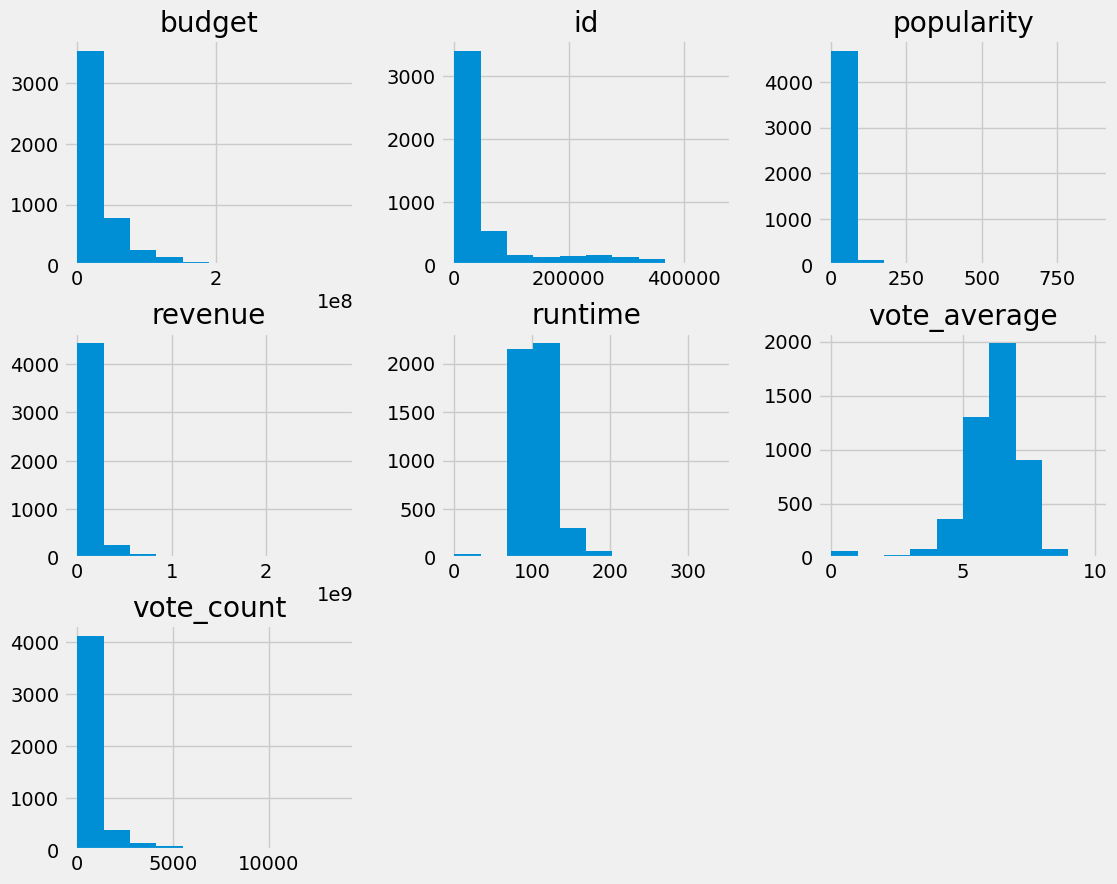

In [6]:
# plot histogram for various parameters of the movie csv file
movies.hist(figsize=(12, 10))
# display graph
plt.show()

In [7]:
# convert genres column from json to string
# for each json data item
for index,i in zip(movies.index,movies['genres'].apply(json.loads)):
    # create a list
    list1 = []
    # for each item in genre column, the name key value is the genre of the movie
    for j in range(len(i)):
        # convert to string and store to list
        list1.append((i[j]['name']))
    # cluster genre from list while searching
    movies.loc[index,'genres'] = str(list1)

# convert keywords column from json to string
# for each json data item
for index,i in zip(movies.index,movies['keywords'].apply(json.loads)):
    # create a list
    list2 = []
    # for each item in keywords column, the name key value is the keyword of the movie
    for j in range(len(i)):
        # convert to string and store to list
        list2.append((i[j]['name']))
    # cluster keywords from list while searching
    movies.loc[index,'keywords'] = str(list2)
    
# convert production_companies column from json to string
# for each json data item
for index,i in zip(movies.index,movies['production_companies'].apply(json.loads)):
    # create a list
    list3 = []
    # for each item in production_companies column, the name key value is the production company name of the movie
    for j in range(len(i)):
        # convert to string and store to list
        list3.append((i[j]['name']))
    # cluster production company name from list while searching
    movies.loc[index,'production_companies'] = str(list3)

# convert runtime column from json to string
movies['runtime'] = movies['runtime'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# convert cast column from json to string
# for each json data item
for index,i in zip(credits.index,credits['cast'].apply(json.loads)):
    # create a list
    list4 = []
    # for each item in cast column, the name key value is the actor and actress name from the movie
    for j in range(len(i)):
        # convert to string and store to list
        list4.append((i[j]['name']))
    # cluster cast from list while searching
    credits.loc[index,'cast'] = str(list4)

# convert cast column from json to string
# load json data item
credits['crew'] = credits['crew'].apply(json.loads)
# separate director from crew list
def director(x):
    # for each role as director
    for i in x:
        # for each job named as Director
        if i['job'] == 'Director':
            # use the name keyword as director name
            return i['name']
# apply function to locate director name
credits['crew'] = credits['crew'].apply(director)
# save crew name as director
credits.rename(columns={'crew':'director'},inplace=True)

Text(0.5, 1.0, 'Total Released Movie by Date')

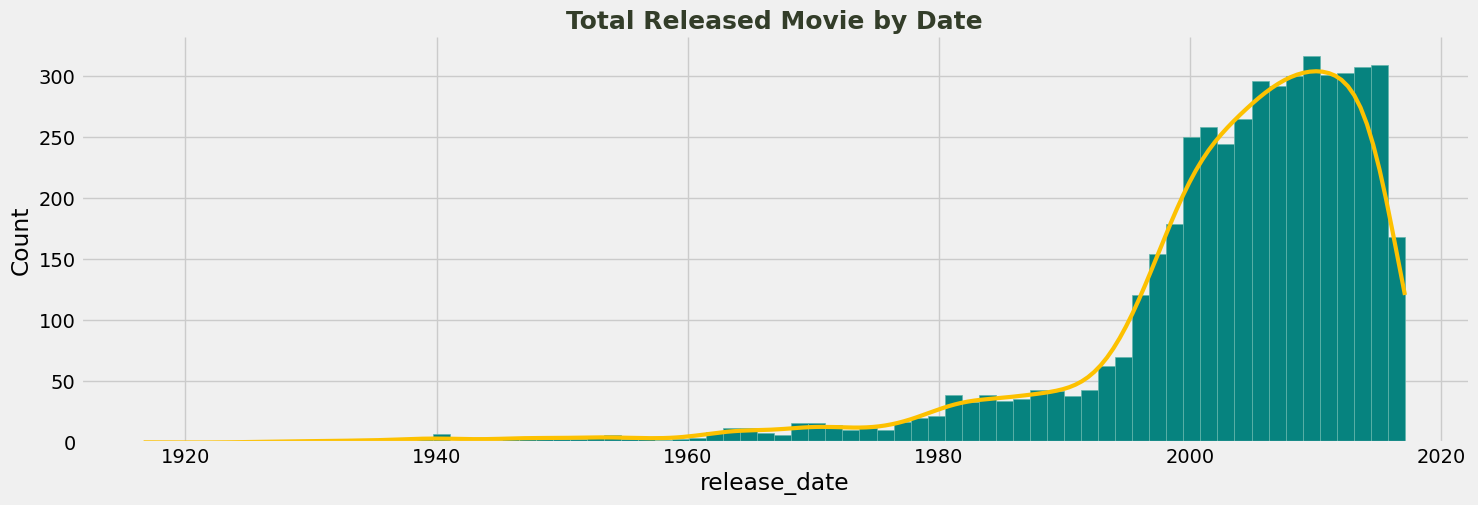

In [8]:
# convert 'release_date' to datetime format
movies['release_date'] = pd.to_datetime(movies['release_date'])
# extract year and store in column 'release_year'
movies['release_year'] = movies['release_date'].dt.year
# plot histogram with release year against movie name
sns.displot(data=movies, x='release_date', kind='hist', kde=True, color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
# display title of graph
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [9]:
# left join credits and movie file data over movie id
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')
# new table now consists of merged columns
movies = movies[['id','original_title','genres','cast','vote_average','director','keywords', 'release_year']]

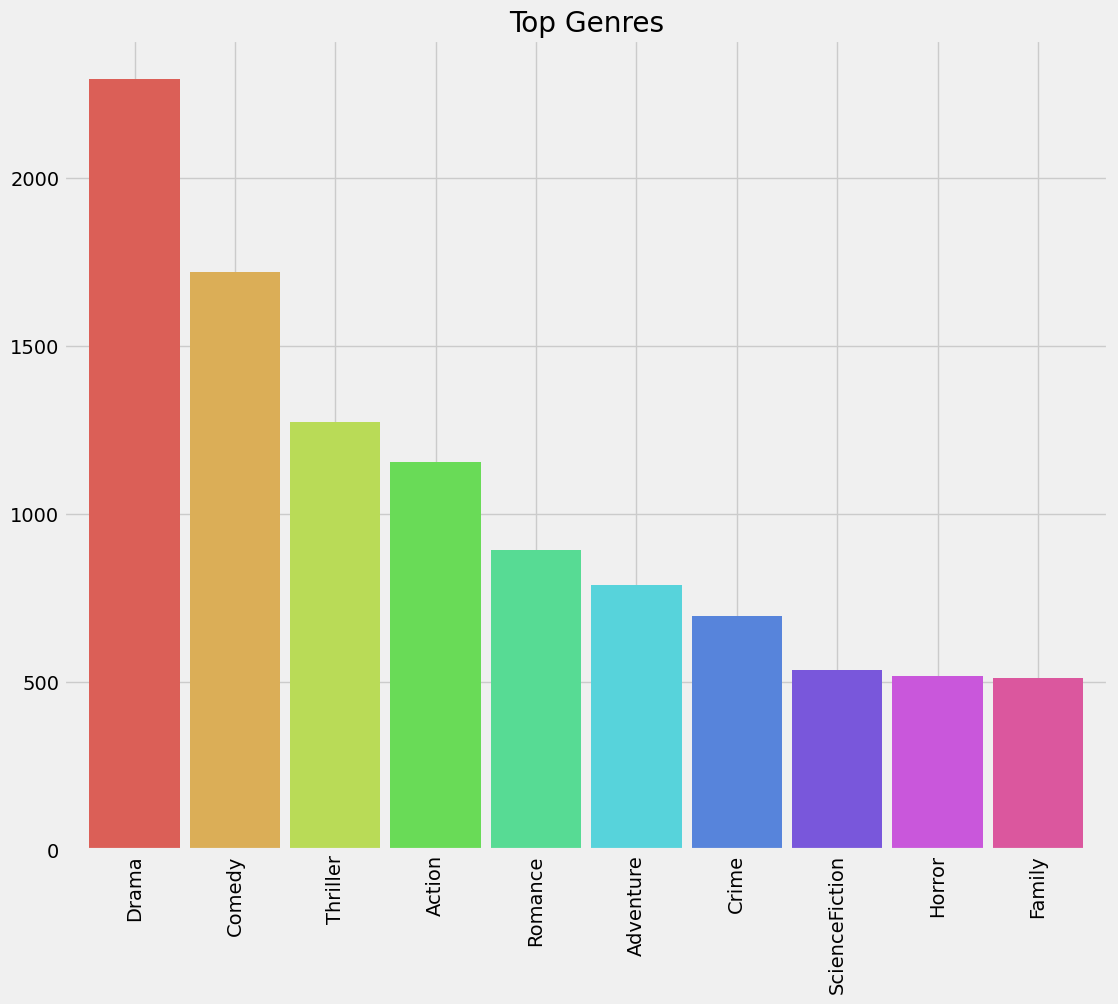

In [10]:
# for each genre with index
for i,j in zip(movies['genres'],movies.index):
    # create empty list
    list5=[]
    list5=i
    # locating movie name with genre in list
    movies.loc[j,'genres']=str(list5)
# strip genre of white spaces and inverted commas to clean list
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
# separate each list itme with comma
movies['genres'] = movies['genres'].str.split(',')
# empty list for storing stripped genre
genreList = []
# for each item in genre list
for index, row in movies.iterrows():
    # check each genre in list to seelct unique genre name
    genres = row["genres"]
    for genre in genres:
        # if genre is not found in existing list, add new to list
        if genre not in genreList:
            genreList.append(genre)
# list with unique genres
genreList[:10]
# plot genres on graph
plt.subplots(figsize=(12,10))
# empty list for each genre with count
list1 = []
# for each genre
for i in movies['genres']:
    # append to list
    list1.extend(i)
# plot each each genre
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=False).plot.bar(width=0.9,color=sns.color_palette('hls',10))
# title of graph
plt.title('Top Genres')
# display graph
plt.show()

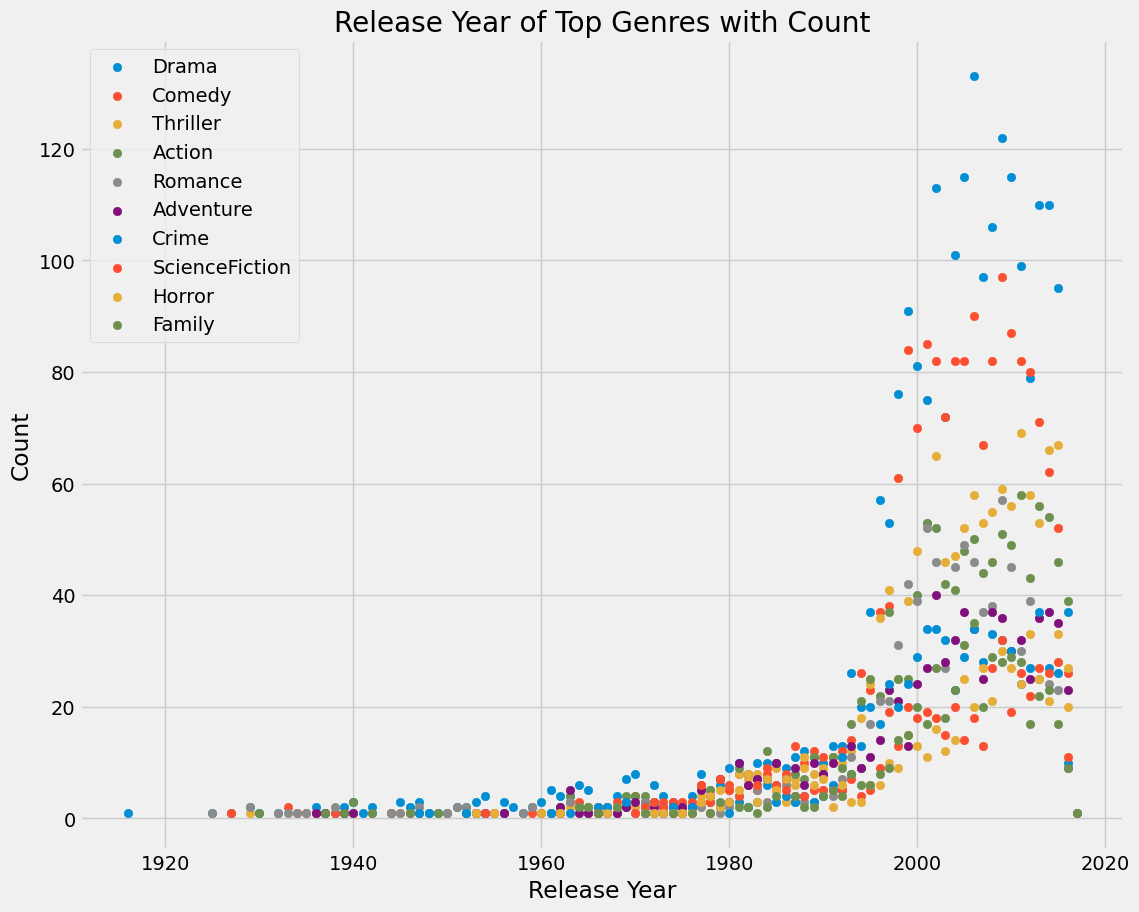

In [11]:
# create release_year and genre DataFrame
df_genres_years = movies[['release_year', 'genres']]
# explode the genres column so each genre has its own row
df_genres_years = movies[['release_year', 'genres']].explode('genres')
# count each genre per year
df_genre_year_count = df_genres_years.groupby(['release_year', 'genres']).size().reset_index(name='count')
# sort top 10 genre from list
top_genres = pd.Series(list1).value_counts()[:10].index.tolist()
# compare against each year
df_genre_year_count_top_genres = df_genre_year_count[df_genre_year_count['genres'].isin(top_genres)]
# plot graph for top genre with count agaisnt each year
plt.figure(figsize=(12,10))
# for each genre in top genre list
for genre in top_genres:
    # count number of genre occurance in each year
    df_genre = df_genre_year_count_top_genres[df_genre_year_count_top_genres['genres'] == genre]
    # scatter plot the genre for count
    plt.scatter(df_genre['release_year'], df_genre['count'], label=genre)
# legend to distinguish between data points
plt.legend()
# title of graph
plt.title('Release Year of Top Genres with Count')
# x axis is year of genre release
plt.xlabel('Release Year')
# number of times movie with genre was released
plt.ylabel('Count')
# display graph
plt.show()

In [12]:
# define binary values for genres
def binary(genre_list):
    # create empty list
    binaryList = []
    # for each genre in list
    for genre in genreList:
        # if genre exists in genrelist
        if genre in genre_list:
            # add to binary list
            binaryList.append(1)
        else:
            # else dont add
            binaryList.append(0)
    # return the final list of genres add to binary lsit
    return binaryList
# convert genre to binary
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))

In [13]:
# strip cast list of white spaces and inverted commas to clean list
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
# separate each list itme with comma
movies['cast'] = movies['cast'].str.split(',')
# for each cast value
for i,j in zip(movies['cast'],movies.index):
    # create empty lsit
    list2 = []
    list2 = i[:4]
    # add cast to list
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
# # strip cast list of white spaces and inverted commas to clean list
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jhana\AppData\Local\Temp\ipykernel_20856\2557133833.py:6: SyntaxWarning: invalid escape sequence '\.'
  movies['cast'] = movies['cast'].apply(lambda x: re.split(',(?![a-zA-Z]+\.)', x))


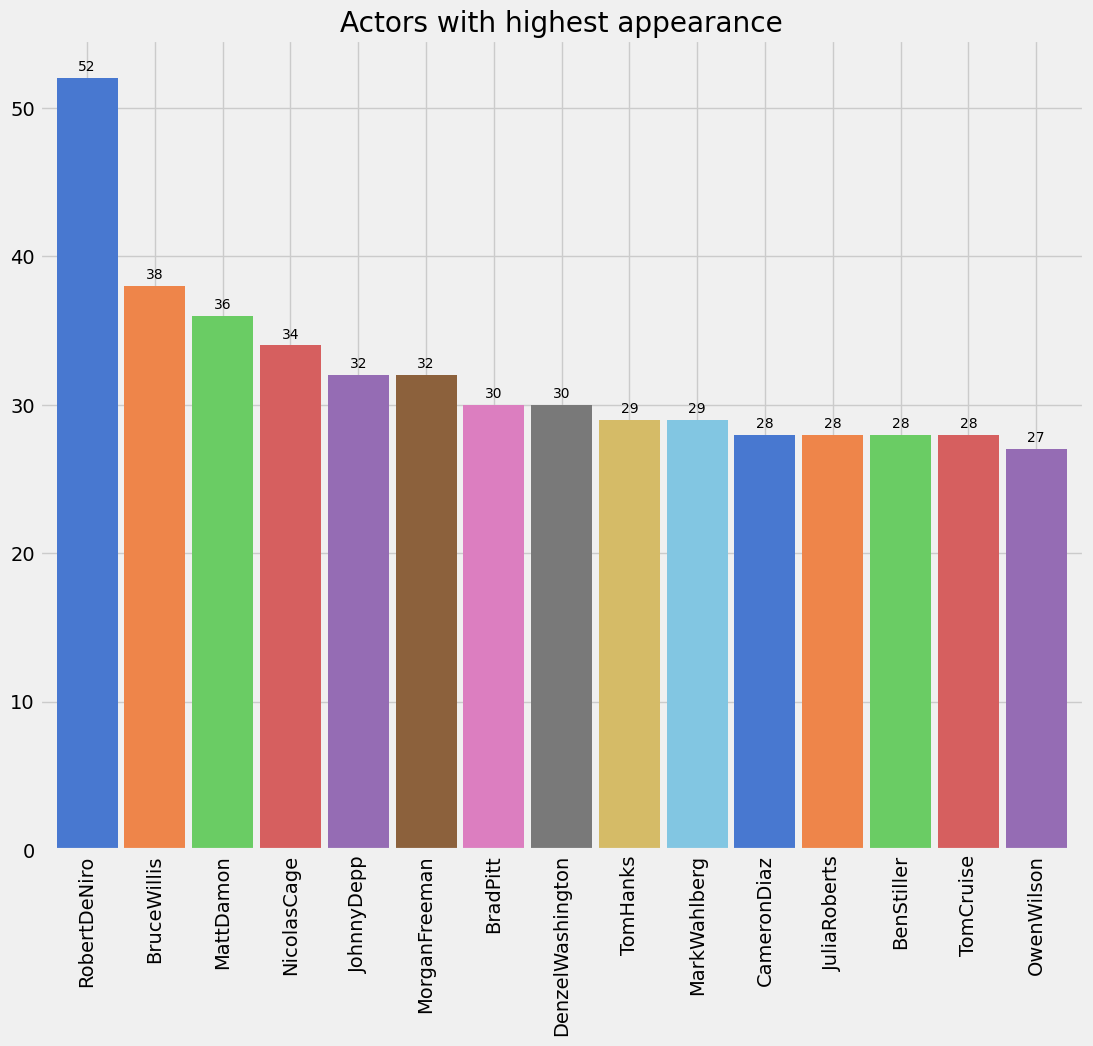

In [14]:
# plot top actors
def plot_top_actors(movies):
    # strip cast list of white spaces and inverted commas to clean list
    movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
    # separate each list item over special characters
    movies['cast'] = movies['cast'].apply(lambda x: re.split(',(?![a-zA-Z]+\.)', x))
    # create empty lsit
    list1 = []
    # add cast to list
    for i in movies['cast']:
        list1.extend(i)
        # if cast name empty, remove from list
    while("" in list1):
        list1.remove("")
    # count appearances for each cast
    values = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).values
    # labels = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).index
    # plot graph
    plt.subplots(figsize=(12,10))
    # split 15 top actors from list with count
    ax = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).plot.bar(width=0.9, color=sns.color_palette('muted',40))
    for i in range(len(values)):
        # display actor names
        ax.text(i, values[i] + 0.5, values[i], fontsize=10, color='black', ha='center')
    # title of graph
    plt.title('Actors with highest appearance')
    # display graph
    plt.show()
# execute function to display top 15 actors
plot_top_actors(movies)


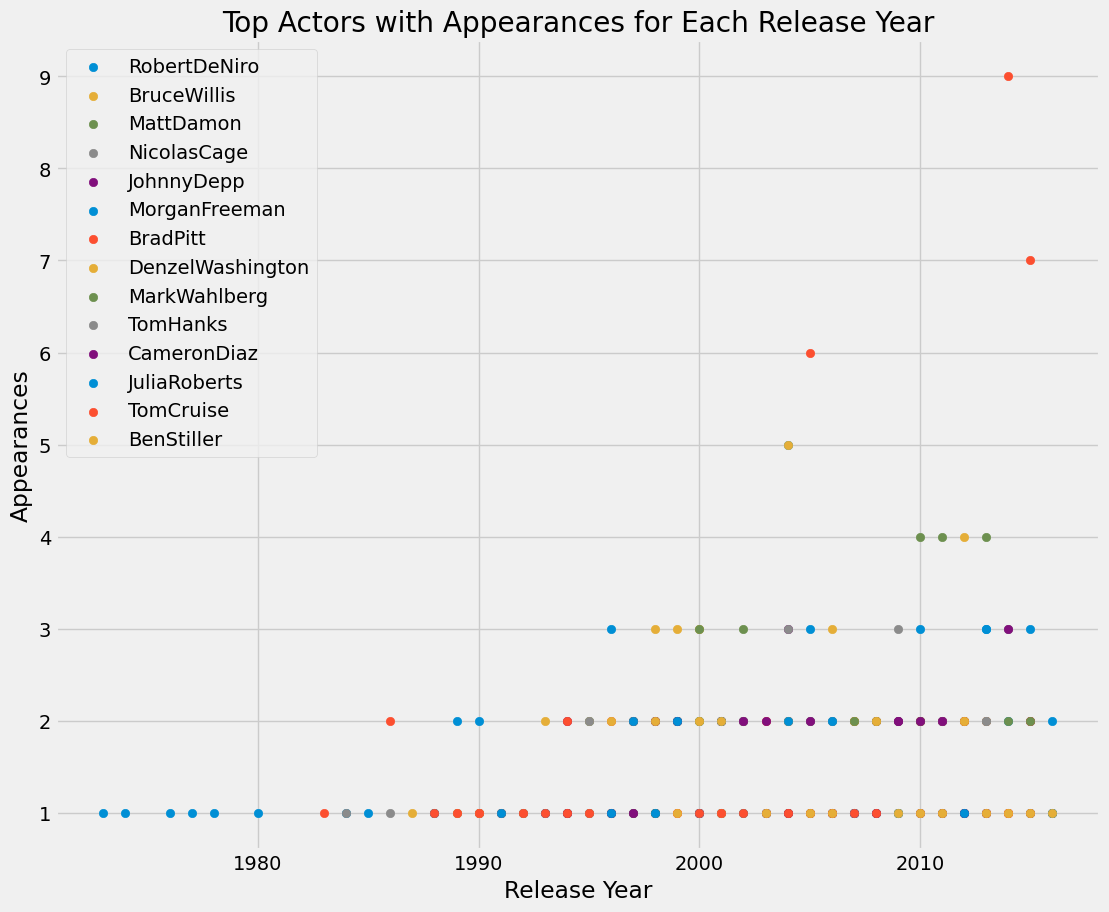

In [15]:
# function to plot actor's appearances
def plot_actor_appearances(movies):
    # create release_year and cast DataFrame
    df_cast_years = movies[['release_year', 'cast']]
    # explode the cast column so each cast has its own row
    df_cast_years = df_cast_years.explode('cast')
    # count each cast appearance per year
    df_actor_year_count = df_cast_years.groupby(['release_year', 'cast']).size().reset_index(name='count')
    # create empty list
    list1 = []
    # for each cast
    for i in movies['cast']:
        list1.extend(i)
    # count top 15 actor appearances
    df_actor_year_count_top_actors = df_actor_year_count[df_actor_year_count['cast'].isin(pd.Series(list1).value_counts()[:15].index.tolist())]
    # plot graph
    plt.figure(figsize=(12,10))
    # for each top actor
    for actor in pd.Series(list1).value_counts()[:15].index.tolist():
        # count year of top appearance
        df_actor = df_actor_year_count_top_actors[df_actor_year_count_top_actors['cast'] == actor]
        # scatter each actor's appearnace
        plt.scatter(df_actor['release_year'], df_actor['count'], label=actor)
        # legned to distinguish actors
    plt.legend()
    # title of grpah
    plt.title('Top Actors with Appearances for Each Release Year')
    # x axis is year of movie release of top actor
    plt.xlabel('Release Year')
    # y axis is count of appearance
    plt.ylabel('Appearances')
    # display grpah
    plt.show()
# execute function to display top 15 actor appearacnes
plot_actor_appearances(movies)


In [16]:
# create empty cast list
castList = []
# for each cast
for index, row in movies.iterrows():
    cast = row["cast"]
    # add to cast list
    for i in cast:
        if i not in castList:
            castList.append(i)
# convert cast list values to binary
def binary(cast_list):
    # create empty lsit
    binaryList = []
    # for each cast
    for cast in castList:
        # if cast in list, add to binary list
        if cast in cast_list:
            binaryList.append(1)
        else:
            # else skip
            binaryList.append(0)
    # return binary list
    return binaryList
# convert each binary list item to binary value
movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))

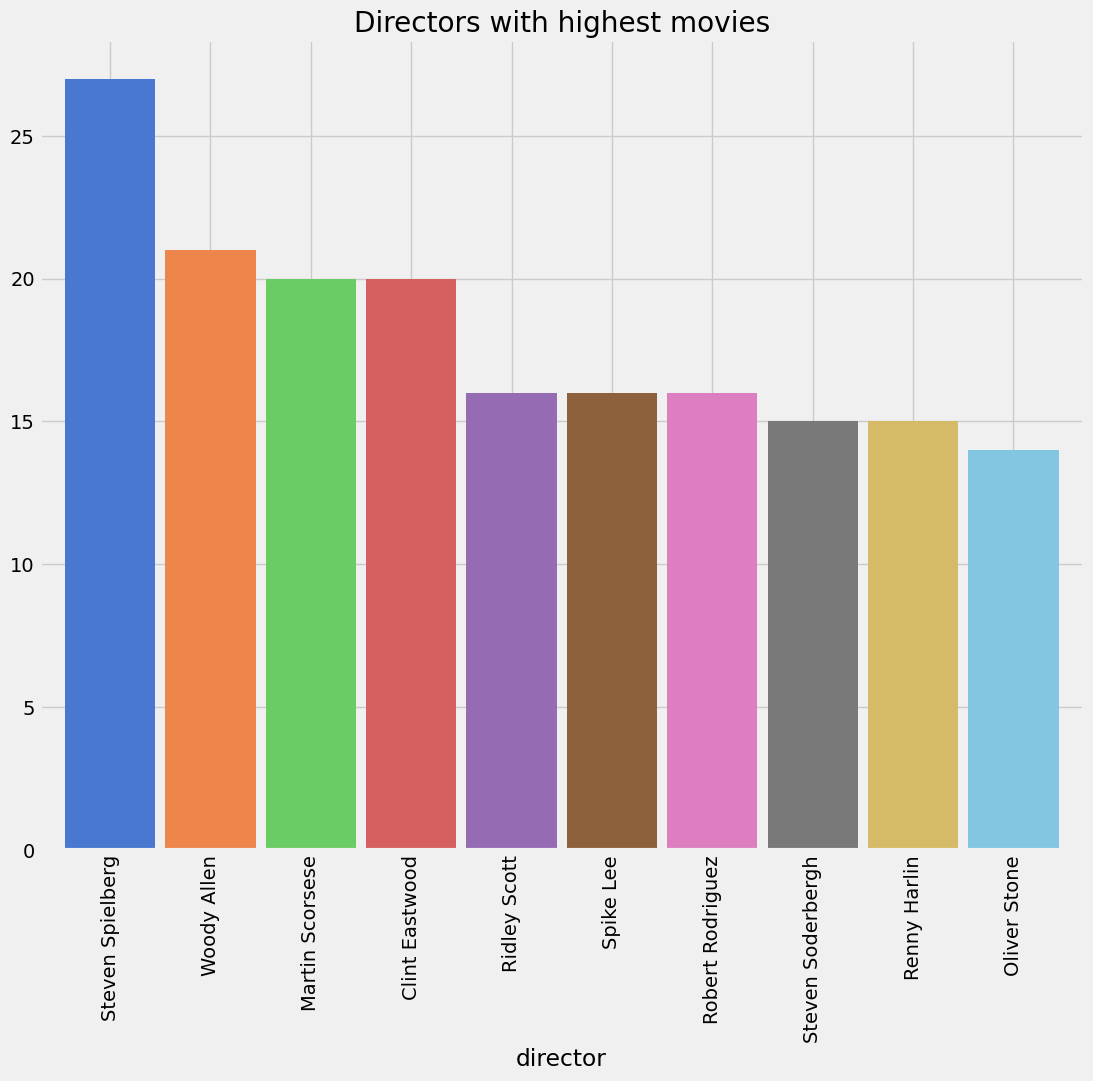

In [17]:
# convert None values to empty strings
def xstr(s):
    if s is None:
        return ''
    return str(s)
# apply xstr function to director column
movies['director'] = movies['director'].apply(xstr)
# plot graph
plt.subplots(figsize=(12,10))
# count top 10 director and display with counts
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=False).plot.bar(width=0.9,color=sns.color_palette('muted',40))
# title of graph
plt.title('Directors with highest movies')
# plot graph
plt.show()

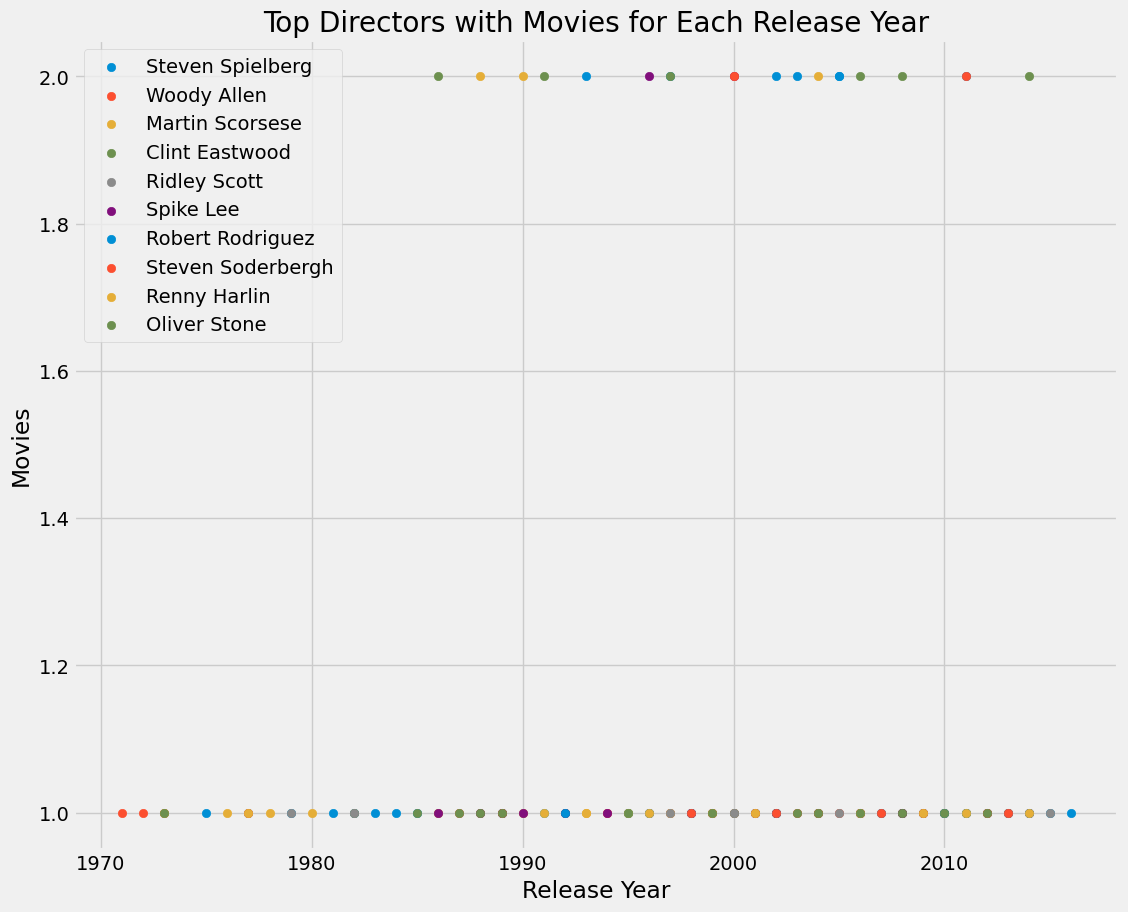

In [18]:
# convert None values to empty strings
def xstr(s):
    if s is None:
        return ''
    return str(s)
# plot director for movie in each year
def plot_director_movies(movies):
    # preprocess director column
    movies['director'] = movies['director'].apply(xstr)
    # create release_year and director DataFrame
    df_director_years = movies[['release_year', 'director']]
    # count director per year
    df_director_year_count = df_director_years.groupby(['release_year', 'director']).size().reset_index(name='count')
    # get top 10 directors
    top_directors = movies[movies['director']!=''].director.value_counts()[:10].index.tolist()
    # plot graph
    plt.figure(figsize=(12,10))
    # for each director, display count over each year
    for director in top_directors:
        df_director = df_director_year_count[df_director_year_count['director'] == director]
        # scatter plot for distinguishing
        plt.scatter(df_director['release_year'], df_director['count'], label=director)
        # legend to distinguish
    plt.legend()
    # title of graph
    plt.title('Top Directors with Movies for Each Release Year')
    # x axis is release year of movie
    plt.xlabel('Release Year')
    # y axis is movie name
    plt.ylabel('Movies')
    # plot grpah
    plt.show()
# execute function to display top directors with movie release for each year
plot_director_movies(movies)


In [19]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)
def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
movies['director_bin'] = movies['director'].apply(lambda x: binary(x))
# movies.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jhana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


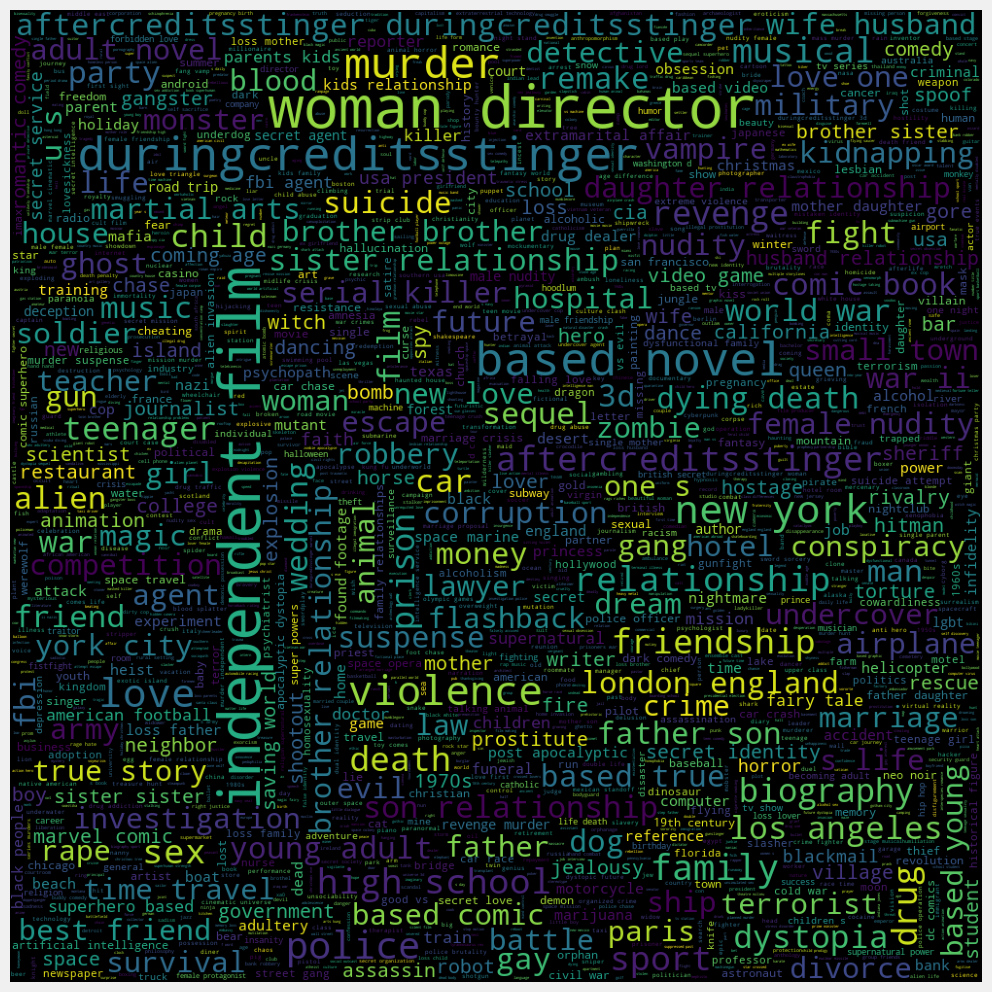

In [20]:
plt.subplots(figsize=(12, 12))

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Create stopwords set
stop_words = set(stopwords.words('english'))
stop_words.update(',', ';', '!', '?', '.', '(', ')', '$', '#', '+', ':', '...', ' ', '')

# Tokenize words and remove stopwords
words = movies['keywords'].dropna().apply(nltk.word_tokenize)
word = []
for i in words:
    word.extend(i)
word = pd.Series(word)
word = [i for i in word.str.lower() if i not in stop_words]

# Generate word cloud
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size=60, width=1000, height=1000)
wc.generate(" ".join(word))

# Display word cloud
plt.imshow(wc)
plt.axis('off')
plt.show()

In [21]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)

In [22]:
words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']








In [23]:
# # Define the runtime bins
# runtime_bins = [0, 60, 90, 120, 150, 180, float('inf')]  # Define your custom bins here

# # Create a function to categorize runtime into bins
# def categorize_runtime(runtime):
#     for i in range(len(runtime_bins) - 1):
#         if runtime_bins[i] <= runtime < runtime_bins[i + 1]:
#             return i

# # Apply the function to create the 'runtime_bin' column
# movies['runtime_bin'] = movies['runtime'].apply(categorize_runtime)

# # Let's see the distribution of movies in each bin
# movies['runtime_bin'].value_counts()

# # Now, you can use this 'runtime_bin' feature similarly to other binary features for recommendations.


# runtime_list = []
# for index, row in movies.iterrows():
#     rt1 = row["runtime"]
    
#     for rt in rt1:
#         if rt not in runtime_list:
#             runtime_list.append(rt)

# def binary(words):
#     binaryList = []
#     for rt in runtime_list:
#         if rt in words:
#             binaryList.append(1)
#         else:
#             binaryList.append(0)
#     return binaryList

# # Create the 'runtime_list' column
# movies['runtime_list'] = movies['runtime'].apply(lambda x: binary(x))




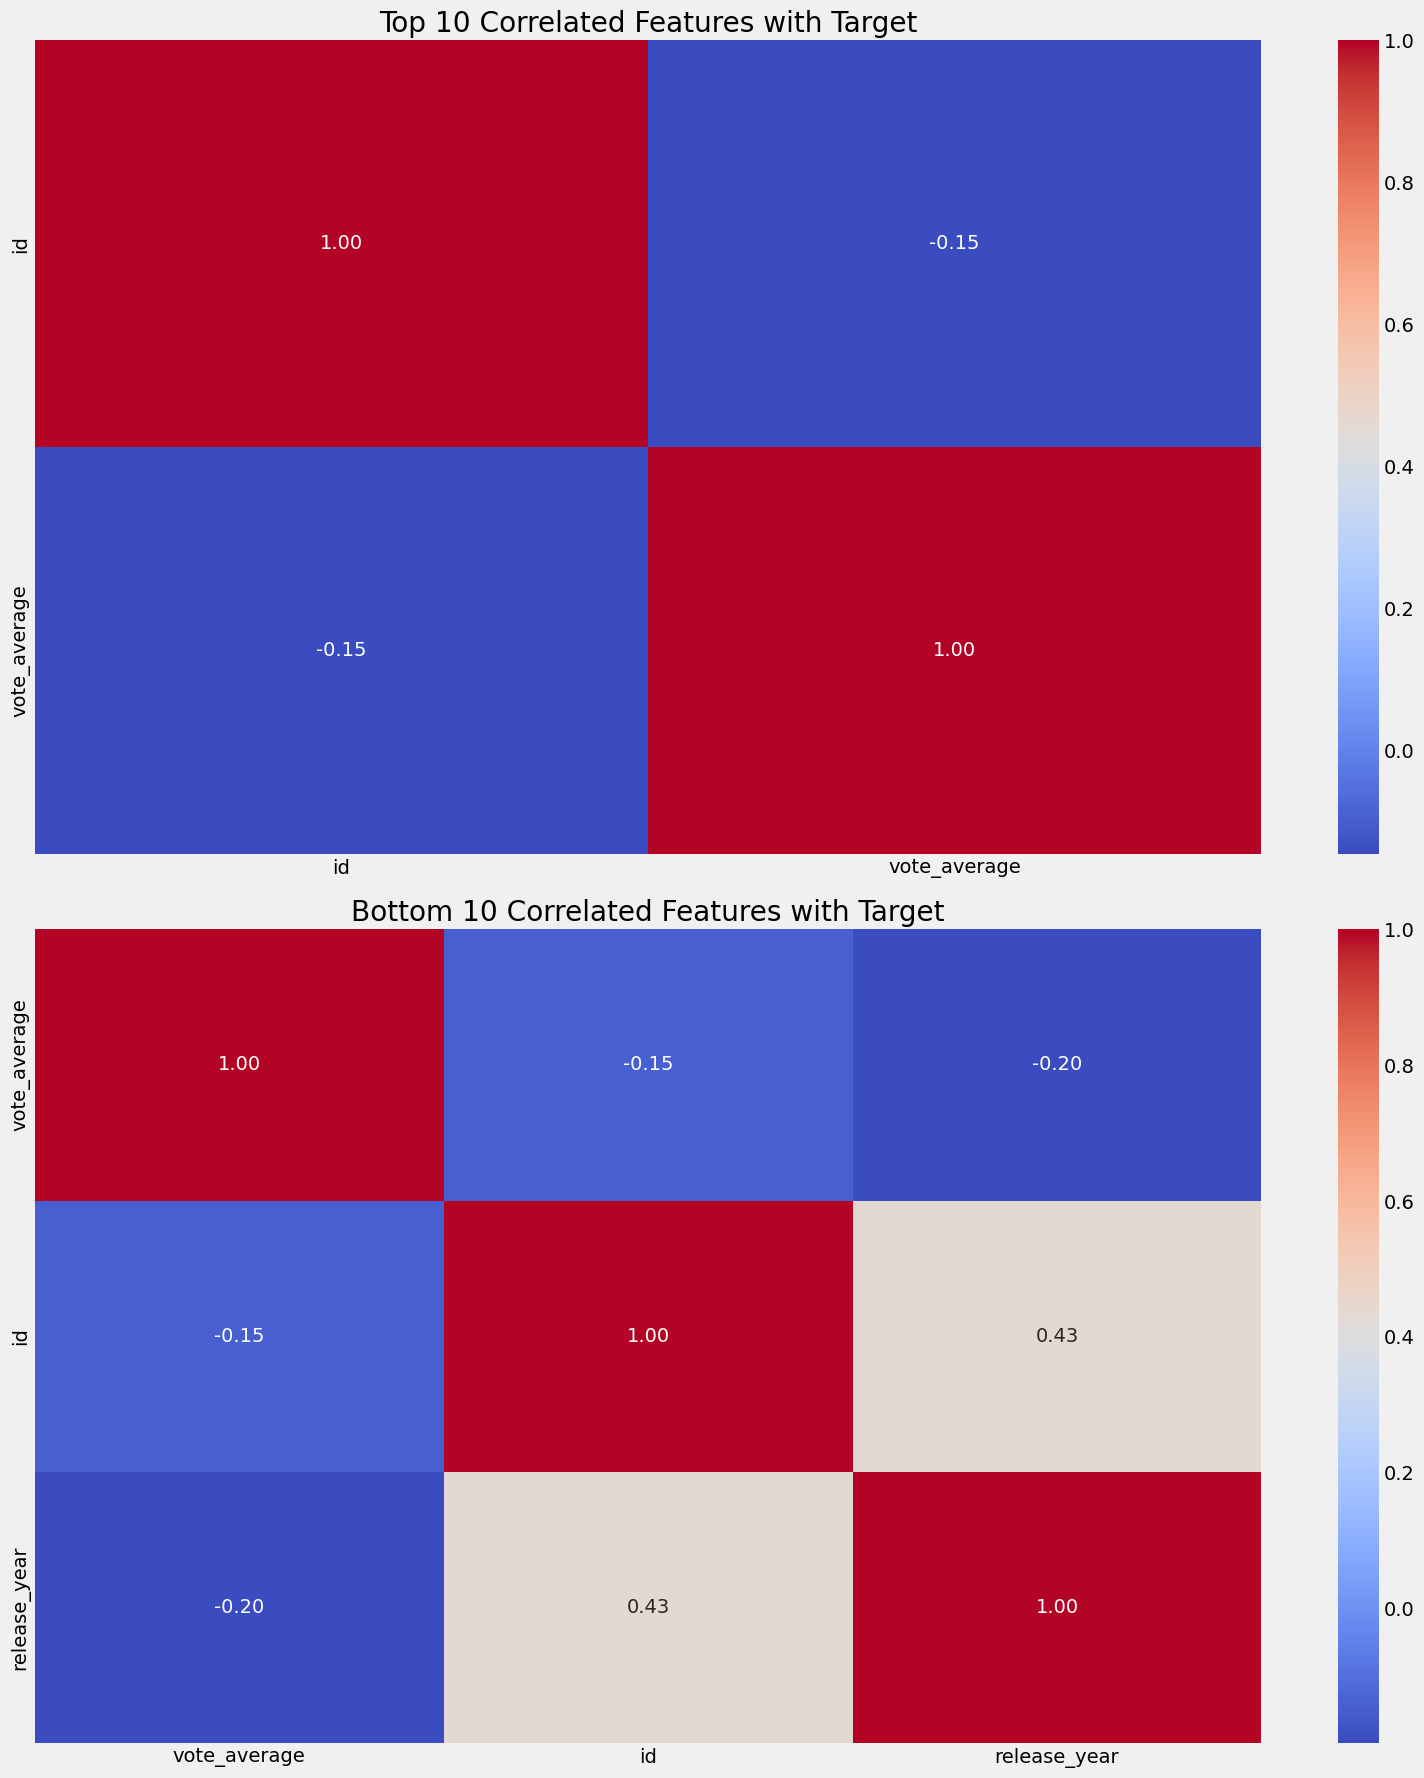

In [24]:

####feature selection

def plot_correlation(movies):
    # Select only numeric columns
    numeric_columns = movies.select_dtypes(include=[np.number])

    # Calculate correlation matrix
    correlation_matrix = numeric_columns.corr()
    correlation_with_target = correlation_matrix['release_year']

    # Top 10 correlated features
    top_10_correlated = correlation_with_target.abs().sort_values(ascending=False).head(10)[1:]  # Exclude the target itself

    # Bottom 10 correlated features
    bottom_10_correlated = correlation_with_target.abs().sort_values(ascending=True).head(10)

    # Select relevant columns from the dataframe
    top_10_df = numeric_columns[top_10_correlated.index]
    bottom_10_df = numeric_columns[bottom_10_correlated.index]

    # Set up subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))

    # Plot top 10 correlated features
    sns.heatmap(top_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
    axes[0].set_title('Top 10 Correlated Features with Target')

    # Plot bottom 10 correlated features
    sns.heatmap(bottom_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
    axes[1].set_title('Bottom 10 Correlated Features with Target')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_correlation(movies)


In [25]:
########################## start from here
def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(wordsA, wordsB)

    # runtimeA = a['runtime_bin']
    # runtimeB = b['runtime_bin']
    # runtimeDistance = spatial.distance.cosine(runtimeA, runtimeB)

    return genreDistance + directDistance + scoreDistance + wordsDistance



# Similarity(3,160) #checking similarity between any 2 random movies
# print(movies.iloc[3])
# print(movies.iloc[160])

In [26]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
# movies.head()

In [27]:
def predict_score(movie_title):
    new_movie = movies[movies['original_title'].str.contains(movie_title)].iloc[0].to_frame().T
    if new_movie.empty:
        print(f"No movie found with title containing '{movie_title}'")
        return None
    print('Selected Movie: ', new_movie.original_title.values[0])

    def getNeighbors(baseMovie, K):
        distances = []

        for index, movie in movies.iterrows():
            if movie['new_id']!= baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))

        distances.sort(key=operator.itemgetter(1))
        neighbors = []

        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)

    print('\nTop 10 Recommendations: \n')
    for neighbor in neighbors[:10]:
        movie = movies.iloc[neighbor[0]]
        print(f"Title: {movie['original_title']}")
        print(f"Director: {movie['director']}")

        if 'keywords' in movie:
            print(f"Keywords: {movie['keywords']}")

        if 'runtime' in movie:
            print(f"Runtime: {movie['runtime']} minutes")

        if 'cast' in movie:
            print(f"Actors: {movie['cast']}")

        print(f"Genres: {movie['genres']}")
        print(f"Rating: {movie['vote_average']:.2f}/10")
        print('---')
        avgRating = avgRating + movie['vote_average']

movie_title = input("Enter the movie title: ")
predict_score(movie_title)

Selected Movie:  Avengers: Age of Ultron

Top 10 Recommendations: 

Title: The Avengers
Director: Joss Whedon
Genres: ['ScienceFiction', 'Action', 'Adventure']
Rating: 7.40/10
---
Title: Captain America: The Winter Soldier
Director: Anthony Russo
Genres: ['Action', 'Adventure', 'ScienceFiction']
Rating: 7.60/10
---
Title: Serenity
Director: Joss Whedon
Genres: ['ScienceFiction', 'Action', 'Adventure', 'Thriller']
Rating: 7.40/10
---
Title: Captain America: The First Avenger
Director: Joe Johnston
Genres: ['Action', 'Adventure', 'ScienceFiction']
Rating: 6.60/10
---
Title: Ant-Man
Director: Peyton Reed
Genres: ['ScienceFiction', 'Action', 'Adventure']
Rating: 7.00/10
---
Title: Captain America: Civil War
Director: Anthony Russo
Genres: ['Adventure', 'Action', 'ScienceFiction']
Rating: 7.10/10
---
Title: Iron Man 2
Director: Jon Favreau
Genres: ['Adventure', 'Action', 'ScienceFiction']
Rating: 6.60/10
---
Title: X-Men
Director: Bryan Singer
Genres: ['Adventure', 'Action', 'ScienceFiction

In [28]:
def calculate_rmse_mape_for_top_movies(data, top_n):
    top_movies = data.sort_values(by='vote_average', ascending=False).head(top_n)
    predictions = []
    targets = []
    for _, movie in top_movies.iterrows():
        predicted_score = predict_score(movie['original_title'])
        if predicted_score is not None:
            actual_score = movie['vote_average']
            predictions.append(predicted_score)
            targets.append(actual_score)
    rmse = sqrt(mean_squared_error(targets, predictions))
    mape = np.mean(np.abs((np.array(targets) - np.array(predictions)) / np.array(targets))) * 100
    return rmse, mape

# Call the function and handle the ValueError
try:
    rmse, mape = calculate_rmse_mape_for_top_movies(movies, 5)
    print(f'Root Mean Squared Error for top 5 movies: {rmse}')
    print(f'Mean Absolute Percentage Error for top 5 movies: {mape}%')
except ValueError as e:
    print(e)

Selected Movie:  Dancer, Texas Pop. 81

Top 10 Recommendations: 

Title: Secondhand Lions
Director: Tim McCanlies
Genres: ['Comedy', 'Drama', 'Family']
Rating: 6.90/10
---
Title: Simon Birch
Director: Mark Steven Johnson
Genres: ['Comedy', 'Drama', 'Family']
Rating: 6.50/10
---
Title: Kit Kittredge: An American Girl
Director: Patricia Rozema
Genres: ['Comedy', 'Drama', 'Family']
Rating: 6.40/10
---
Title: American Dreamz
Director: Paul Weitz
Genres: ['Comedy', 'Drama', 'Family']
Rating: 4.90/10
---
Title: Three Men and a Baby
Director: Leonard Nimoy
Genres: ['Family', 'Comedy', 'Drama']
Rating: 5.80/10
---
Title: Harriet the Spy
Director: Bronwen Hughes
Genres: ['Comedy', 'Drama', 'Family']
Rating: 5.70/10
---
Title: Annie
Director: Will Gluck
Genres: ['Comedy', 'Drama', 'Family']
Rating: 6.00/10
---
Title: Ice Princess
Director: Tim Fywell
Genres: ['Drama', 'Comedy', 'Family']
Rating: 5.90/10
---
Title: Air Bud
Director: Charles Martin Smith
Genres: ['Comedy', 'Family', 'Drama']
Ratin